# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

We read the data, limiting the size of the training set to 4'000'000 rows:

In [6]:
nrows = 1000000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('train.csv',#nrows=nrows,
                    usecols = retained_columns,
                    dtype = dtypes)
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')


In [7]:
test = pd.read_csv('test.csv',#nrows=500000,
                   usecols = retained_columns,
                   dtype = dtypes)

In [8]:
target = train['HasDetections']
del train['HasDetections']

In [9]:
mean_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab',
    'IeVerIdentifier',
    'Census_OSBuildRevision',
    'GeoNameIdentifier',
    'LocaleEnglishNameIdentifier'
]

In [10]:
len(train),len(test)

(8921483, 7853253)

In [11]:
for column in mean_encoded_variables:
    trn, sub = target_encode(train[column], 
                             test[column], 
                             target=target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    train=pd.concat([train,trn],axis=1)
    test=pd.concat([test,sub],axis=1)

In [12]:
len(train),len(test)

(8921483, 7853253)

In [13]:
all=pd.concat([train, test])

In [14]:
(all.head())

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean,IeVerIdentifier_mean,Census_OSBuildRevision_mean,GeoNameIdentifier_mean,LocaleEnglishNameIdentifier_mean
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.498047,0.507828,0.462401,0.583421,0.537802,0.506889,0.503133,0.554175,0.507356,0.501494,0.558829,0.522923,0.519678,0.558433,0.512514,0.510654
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2404.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0.501276,0.494814,0.412226,0.471977,0.523178,0.498821,0.489900,0.560739,0.506318,0.496991,0.529476,0.519862,0.519831,0.528872,0.507542,0.500648
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4908.0,317701.0,4.0,5.0,1972.0,NaN,1

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [15]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
for i in mean_encoded_variables:
    true_numerical_columns.append(i+"_mean")

We also list binary variables, since they can be treated as numericals by tree methods:

In [16]:
binary_variables = [c for c in all.columns if all[c].nunique() == 2]

In [17]:
len(train.columns)

98

to finally make a census of the categorical variables:

In [18]:
categorical_columns = [c for c in all.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [19]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [20]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, all[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [21]:
def frequency_encoding(variable):
    t = all[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [22]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'CountryIdentifier',
    'AVProductStatesIdentifier',
    'DefaultBrowsersIdentifier',
    'Census_FirmwareManufacturerIdentifier',
    'Census_OSVersion',
    'OsBuildLab',
    'IeVerIdentifier',
    'Census_OSBuildRevision',
    'GeoNameIdentifier',
    'LocaleEnglishNameIdentifier'
]

In [23]:
for variable in tqdm(frequency_encoded_variables):
    
    freq_enc_dict = frequency_encoding(variable)
    all[variable] = all[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    #test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████████████████████████████████████| 16/16 [02:49<00:00, 10.15s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [24]:
all.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,Census_OEMModelIdentifier_mean,CityIdentifier_mean,Census_FirmwareVersionIdentifier_mean,AvSigVersion_mean,Census_ProcessorModelIdentifier_mean,Census_OEMNameIdentifier_mean,CountryIdentifier_mean,AVProductStatesIdentifier_mean,DefaultBrowsersIdentifier_mean,Census_FirmwareManufacturerIdentifier_mean,Census_OSVersion_mean,OsBuildLab_mean,IeVerIdentifier_mean,Census_OSBuildRevision_mean,GeoNameIdentifier_mean,LocaleEnglishNameIdentifier_mean
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,134.0,0,7.0,0,NaN,0.0,1.0,1.0,1,1.0,205.0,18.0,4.0,5.0,windows10,x64,10.0.0.0,17134,256,rs4,0.0,Pro,1.0,0,NaN,0.0,0.0,NaN,1.0,1.0,Desktop,Windows.Desktop,0.0,22022.0,4.0,5.0,135.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,3.0,amd64,rs4_release,17134,3.0,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,1.0,2572.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.498047,0.507828,0.462401,0.583421,0.537802,0.506889,0.503133,0.554175,0.507356,0.501494,0.558829,0.522923,0.519678,0.558433,0.512514,0.510654
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,0.0,0,7.0,0,NaN,0.0,1.0,1.0,1,4.0,171.0,18.0,11.0,12.0,windows10,x64,10.0.0.0,17134,256,rs4,0.0,Pro,1.0,0,NaN,0.0,0.0,NaN,1.0,1.0,Notebook,Windows.Desktop,0.0,118655.0,4.0,5.0,134.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,19.0,amd64,rs4_release,17134,16.0,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,1.0,1415.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0.501276,0.494814,0.412226,0.471977,0.523178,0.498821,0.489900,0.560739,0.506318,0.496991,0.529476,0.519862,0.519831,0.528872,0.507542,0.500648
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,336.0,0,7.0,0,NaN,0.0,1.0,1.0,1,55.0,673.0,18.0,46.0,48.0,windows10,x64,10.0.0.0,17134,768,rs4,0.0,Home,1.0,0,NaN,0.0,0.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,10.0,2.0,4.0,5.0,191.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,3.0,amd64,rs4_release,17134,3.0,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0

In [25]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(all[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    all[col] = indexer[col].get_indexer(all[col])
    #test[col] = indexer[col].get_indexer(test[col])

100%|██████████████████████████████████████████| 38/38 [51:10<00:00, 96.85s/it]


In [26]:
#all = reduce_mem_usage(all)
#test = reduce_mem_usage(test)

In [27]:
all.dtypes

MachineIdentifier                               object
ProductName                                      int64
EngineVersion                                    int64
AppVersion                                       int64
AvSigVersion                                   float64
IsBeta                                            int8
RtpStateBitfield                                 int64
IsSxsPassiveMode                                  int8
DefaultBrowsersIdentifier                      float64
AVProductStatesIdentifier                      float64
AVProductsInstalled                              int64
AVProductsEnabled                                int64
HasTpm                                            int8
CountryIdentifier                              float64
CityIdentifier                                 float64
OrganizationIdentifier                           int64
GeoNameIdentifier                              float64
LocaleEnglishNameIdentifier                    float64
Platform  

In [28]:
for column in all.columns[0:82]:
    if all[column].dtypes=='object':
        all[column]=all[column].astype('category')

In [29]:
train=all[0:len(train)]
test=all[len(train):len(all)]

In [30]:
len(all),len(train),len(test)

(16774736, 8921483, 7853253)

<a id="3"></a> <br>
## 3. Training the model

In [31]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [32]:
max_iter = 5

In [33]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730085	valid_1's auc: 0.728679
[200]	training's auc: 0.736805	valid_1's auc: 0.734514
[300]	training's auc: 0.740128	valid_1's auc: 0.736853
[400]	training's auc: 0.742451	valid_1's auc: 0.738158
[500]	training's auc: 0.744451	valid_1's auc: 0.73918
[600]	training's auc: 0.746127	valid_1's auc: 0.739835
[700]	training's auc: 0.74765	valid_1's auc: 0.740383
[800]	training's auc: 0.749059	valid_1's auc: 0.740753
[900]	training's auc: 0.750343	valid_1's auc: 0.741049
[1000]	training's auc: 0.751545	valid_1's auc: 0.741235
[1100]	training's auc: 0.752772	valid_1's auc: 0.741479
[1200]	training's auc: 0.753932	valid_1's auc: 0.741672
[1300]	training's auc: 0.755071	valid_1's auc: 0.741845
[1400]	training's auc: 0.756152	valid_1's auc: 0.741978
[1500]	training's auc: 0.757195	valid_1's auc: 0.742096
[1600]	training's auc: 0.758245	valid_1's auc: 0.742191
[1700]	training's auc: 0.759271	valid_1's auc: 0.742

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730143	valid_1's auc: 0.729097
[200]	training's auc: 0.736937	valid_1's auc: 0.734956
[300]	training's auc: 0.740121	valid_1's auc: 0.737136
[400]	training's auc: 0.742502	valid_1's auc: 0.738491
[500]	training's auc: 0.744354	valid_1's auc: 0.739292
[600]	training's auc: 0.746016	valid_1's auc: 0.739907
[700]	training's auc: 0.747593	valid_1's auc: 0.740453
[800]	training's auc: 0.74905	valid_1's auc: 0.740932
[900]	training's auc: 0.750363	valid_1's auc: 0.741233
[1000]	training's auc: 0.751632	valid_1's auc: 0.741506
[1100]	training's auc: 0.752817	valid_1's auc: 0.741709
[1200]	training's auc: 0.753988	valid_1's auc: 0.741918
[1300]	training's auc: 0.755109	valid_1's auc: 0.742059
[1400]	training's auc: 0.756201	valid_1's auc: 0.742229
[1500]	training's auc: 0.757276	valid_1's auc: 0.742337
[1600]	training's auc: 0.758308	valid_1's auc: 0.742427
[1700]	training's auc: 0.759326	valid_1's auc: 0.74

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.729975	valid_1's auc: 0.728613
[200]	training's auc: 0.736947	valid_1's auc: 0.734731
[300]	training's auc: 0.740184	valid_1's auc: 0.737041
[400]	training's auc: 0.742482	valid_1's auc: 0.738311
[500]	training's auc: 0.744331	valid_1's auc: 0.739122
[600]	training's auc: 0.746025	valid_1's auc: 0.73977
[700]	training's auc: 0.747575	valid_1's auc: 0.740324
[800]	training's auc: 0.748929	valid_1's auc: 0.740673
[900]	training's auc: 0.750238	valid_1's auc: 0.740985
[1000]	training's auc: 0.751502	valid_1's auc: 0.741262
[1100]	training's auc: 0.752736	valid_1's auc: 0.741497
[1200]	training's auc: 0.753906	valid_1's auc: 0.741698
[1300]	training's auc: 0.75499	valid_1's auc: 0.741837
[1400]	training's auc: 0.756141	valid_1's auc: 0.74202
[1500]	training's auc: 0.757178	valid_1's auc: 0.742107
[1600]	training's auc: 0.758223	valid_1's auc: 0.742238
[1700]	training's auc: 0.759257	valid_1's auc: 0.7423

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.729938	valid_1's auc: 0.729707
[200]	training's auc: 0.736783	valid_1's auc: 0.735586
[300]	training's auc: 0.739974	valid_1's auc: 0.737785
[400]	training's auc: 0.742313	valid_1's auc: 0.739083
[500]	training's auc: 0.744202	valid_1's auc: 0.739958
[600]	training's auc: 0.746023	valid_1's auc: 0.740782
[700]	training's auc: 0.747585	valid_1's auc: 0.741329
[800]	training's auc: 0.748979	valid_1's auc: 0.741734
[900]	training's auc: 0.750319	valid_1's auc: 0.742063
[1000]	training's auc: 0.751618	valid_1's auc: 0.742359
[1100]	training's auc: 0.752823	valid_1's auc: 0.742585
[1200]	training's auc: 0.753965	valid_1's auc: 0.742746
[1300]	training's auc: 0.755069	valid_1's auc: 0.742886
[1400]	training's auc: 0.756159	valid_1's auc: 0.743015
[1500]	training's auc: 0.75726	valid_1's auc: 0.743183
[1600]	training's auc: 0.758268	valid_1's auc: 0.74328
[1700]	training's auc: 0.759246	valid_1's auc: 0.743

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.730241	valid_1's auc: 0.728488
[200]	training's auc: 0.737114	valid_1's auc: 0.734484
[300]	training's auc: 0.740436	valid_1's auc: 0.736832
[400]	training's auc: 0.74274	valid_1's auc: 0.738093
[500]	training's auc: 0.74447	valid_1's auc: 0.738784
[600]	training's auc: 0.746186	valid_1's auc: 0.739471
[700]	training's auc: 0.747812	valid_1's auc: 0.740077
[800]	training's auc: 0.749267	valid_1's auc: 0.740497
[900]	training's auc: 0.750649	valid_1's auc: 0.740888
[1000]	training's auc: 0.751888	valid_1's auc: 0.741133
[1100]	training's auc: 0.753072	valid_1's auc: 0.741327
[1200]	training's auc: 0.75416	valid_1's auc: 0.741466
[1300]	training's auc: 0.755239	valid_1's auc: 0.741581
[1400]	training's auc: 0.756284	valid_1's auc: 0.741689
[1500]	training's auc: 0.757303	valid_1's auc: 0.741796
[1600]	training's auc: 0.758363	valid_1's auc: 0.741887
[1700]	training's auc: 0.759394	valid_1's auc: 0.7420

<a id="4"></a> <br>
## 4. Feature importance

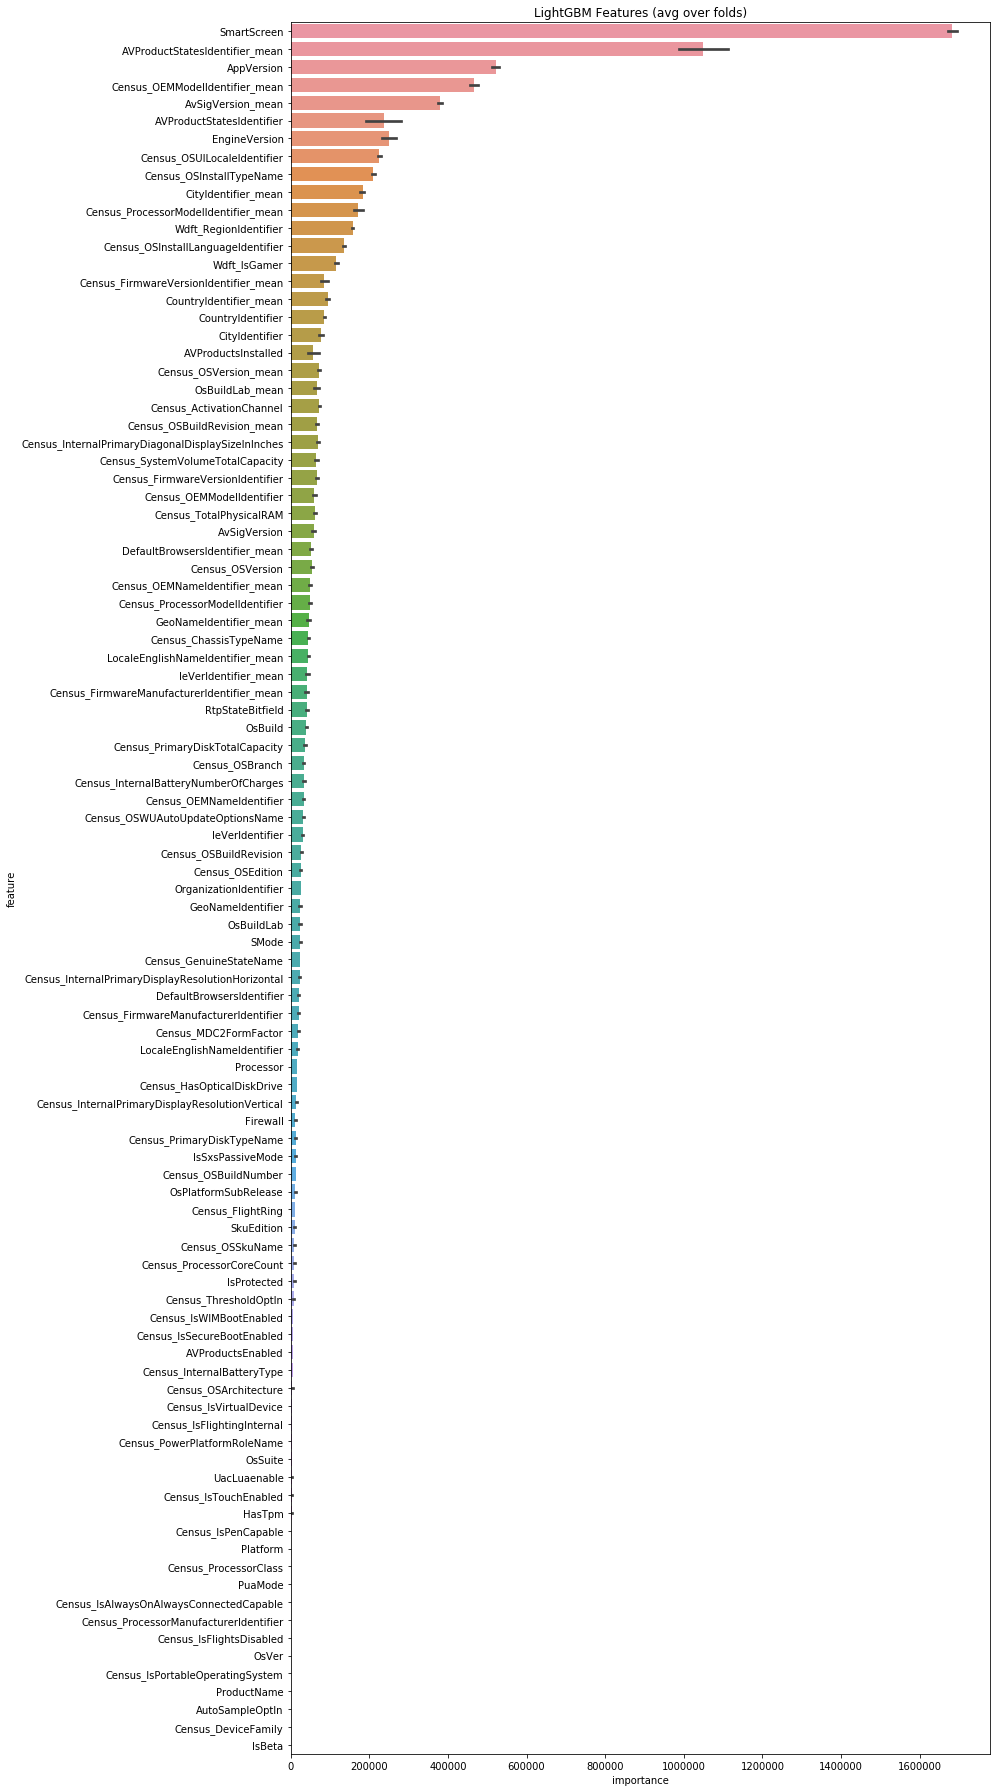

In [34]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [35]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
print(len(sub_df))
sub_df["HasDetections"] = predictions

7853253


In [36]:
len(sub_df["HasDetections"])

7853253

In [37]:
from datetime import datetime as dt
score=metrics.roc_auc_score(target, oof)
filename = 'subm_{:.6f}meanencodidng{}_{}.csv'.format(score, 'Feature_Encoding_LGBM', dt.now().strftime('%Y-%m-%d-%H-%M'))
sub_df.to_csv(filename, index=False)

In [ ]:
sub_df.to_csv('submission.csv.gz', index=False, compression='gzip')